In [1]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import time

import warnings
warnings.filterwarnings('ignore')

## Objetivo



### Carregando conjunto de dados

Vamos utilizar o mesmo conjunto de dados do notebook do SVM (aula_01). O conjunto de dados 20 newsgroups disponível no scikit-learn. Esse conjunto de dados possui aproximadamente 18000 newsgroups posts categorizados em 20 tópicos dividos em dois conjuntos: um para treino e outro para teste (em outras palavras, para avaliação de desempenho do modelo). A divisão entre conjunto de treino e teste basedo em mensagens postadas antes e depois uma data específica.


Vamos então carregá-lo e fazer a transformação para espaço vetorial como **bag-of-words** usando o scikit-learn.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

train_20ng = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'quotes', 'footers'))
test_20ng = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers', 'quotes', 'footers'))

# transforma dados textuais em uma representação vetorial usando
# bag-of-words
vec = CountVectorizer(stop_words='english', min_df=2)

X_train = vec.fit_transform(train_20ng.data)
y_train = train_20ng.target

X_test = vec.transform(test_20ng.data)
y_test = test_20ng.target

print("N. de Exmplos de Treino: %d; N. de Atributos: %d" % X_train.shape)
print("N. de Exmplos de Teste: %d; N. de Atributos: %d" % X_test.shape)

N. de Exmplos de Treino: 11314; N. de Atributos: 39115
N. de Exmplos de Teste: 7532; N. de Atributos: 39115


## Holdout

Vamos utilizar a técnica holdout para selecionar o parâmetro C do svm, profundidae máxima de um àrvore de Decisão, e o hiperparâmetro da regressão logística. Lembre-se que no holdout nós dividimos o conjunto de dados em 3 conjuntos distintos, um para treino (avaliação de performance), validação (seleção do modelo/parâmetros) e treino.

O scikit já divide o conjunto de dados em treino e teste, como pode ser notado acima. Desse modo vamos apenas dividir o conjunto de treino em dois (validação e treino).

In [3]:
from sklearn.model_selection import train_test_split
X_train_aux, X_valid, y_train_aux, y_valid = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

Quais valores de C escolher? Então, testar todos os valores de C pode ser inviável. Desse modo nós podemos chutar alguns valores que façam sentidos. Por exemplos, valores pequenos, médio e grandes, e assim testá-los.

In [4]:
Cs = 2. ** np.arange(-12, -2, 0.25)
Cs

array([ 0.00024414,  0.00029033,  0.00034527,  0.00041059,  0.00048828,
        0.00058067,  0.00069053,  0.00082119,  0.00097656,  0.00116134,
        0.00138107,  0.00164238,  0.00195312,  0.00232267,  0.00276214,
        0.00328475,  0.00390625,  0.00464534,  0.00552427,  0.0065695 ,
        0.0078125 ,  0.00929068,  0.01104854,  0.01313901,  0.015625  ,
        0.01858136,  0.02209709,  0.02627801,  0.03125   ,  0.03716272,
        0.04419417,  0.05255603,  0.0625    ,  0.07432544,  0.08838835,
        0.10511205,  0.125     ,  0.14865089,  0.1767767 ,  0.2102241 ])

Desse modo, para cada valor de C vamos aprender um modelo usando nosso ```X_train_aux``` e então avaliá-lo usando alguma métrica e o valores preditos no conjunto de ```X_valid```.

In [5]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.base import clone

svm = LinearSVC(random_state=0)

def holdout(clf, param_valores):
    best_score = 0
    best_param = 0
    for param, valores in param_valores.items():
        resultados = np.zeros((valores.shape[0], 4))
        
        # Para cada valor dos hiperparâmetro
        # nós criamos um modelo diferente com 
        # conjunto de treino auxiliar. 
        # Após termos o modelo com tal parâmetro,
        # fazemos a predição no conjunto de validação
        # e utilizamos alguma métrica para
        # obtermos um score para aquele método, e então,
        # escolher o paramêtro (ou conjunto de parâmetros)
        # gerou o modelo com maior score.
        for i, val in enumerate(valores):
            # clonando classificador e atribuindo o parametro
            classificador = clone(clf)
            classificador.set_params(**{param: val})
            
            # aprendendo um modelo baseado no conjunto de treino auxiliar
            classificador.fit(X_train_aux, y_train_aux)
            
            # predição baseada no conjunto de validação
            y_pred = classificador.predict(X_valid)

            # score para avaliação do modelo.
            score = f1_score(y_valid, y_pred, average="macro")

            # melhor parâmetro de acordo com score
            if best_score < score:
                best_score = score
                best_param = val

            # score no conjunto de validação, treino e teste para cada um dos valores do parâmetro
            # vamos utilizar isso para traçar a curva do compromisso viés e variância
            resultados[i, 0] = val
            resultados[i, 1] = 1 - score
            resultados[i, 2] = 1 - f1_score(y_train_aux, classificador.predict(X_train_aux), average="macro")
            resultados[i, 3] = 1 - f1_score(y_test, classificador.predict(X_test), average="macro")
        
    
    print("Melhor F1 : %f; Melhor %s : %f" % (best_score, param, best_param))
    return resultados, best_score, best_param

resultados, best_score, best_param = holdout(svm, {'C': Cs})           

Melhor F1 : 0.713817; Melhor C : 0.011049


In [6]:
svm.set_params(**{'C': best_param})
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

score = f1_score(y_test, y_pred, average="macro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.645750


In [7]:
svm.set_params(**{'C': best_param})
svm.fit(X_train_aux, y_train_aux)
y_pred = svm.predict(X_valid)

score = f1_score(y_valid, y_pred, average="macro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.713817


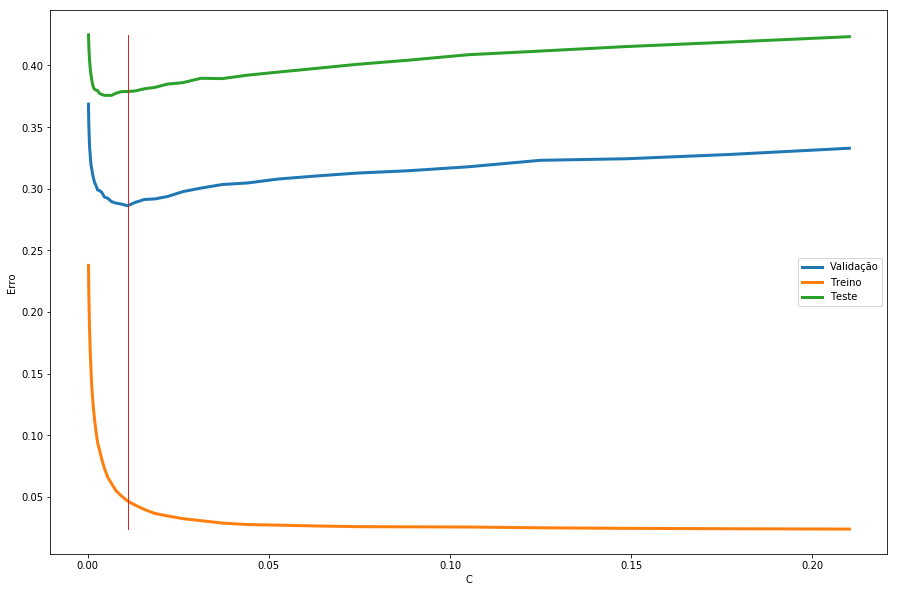

In [8]:
def plot_bias_variance_tradeoff(resultados, param, labels, best_param = None):
    for j in range(resultados.shape[1] - 1):
        plt.plot(resultados[:, 0], resultados[:, j + 1],
                 linewidth=3., label=labels[j])
    if best_param:
        plt.plot([best_param, best_param], [resultados[:,1:].min(), resultados[:,1:].max()],
                 linewidth=1)
    plt.xlabel(param)
    plt.ylabel("Erro")
    plt.legend(loc="best")
        
labels = ['Validação', 'Treino', 'Teste']
plot_bias_variance_tradeoff(resultados, "C", labels, best_param)

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0, max_features=1.0)

profundidades = np.array([1, 5, 8, 25] + list(range(50, 130, 10)) + [200, 250, 300, 350, 500, 800, 1000])

resultados, best_score, best_param = holdout(dt, {'max_depth': profundidades})

Melhor F1 : 0.471080; Melhor max_depth : 200.000000


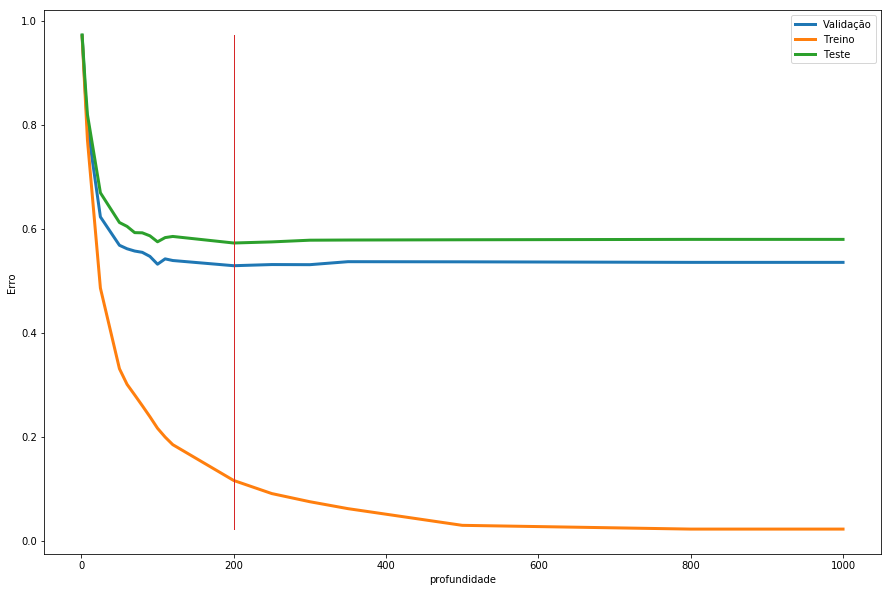

In [10]:
plot_bias_variance_tradeoff(resultados, "profundidade", labels, best_param)

Melhor F1 : 0.701559; Melhor C : 0.297302


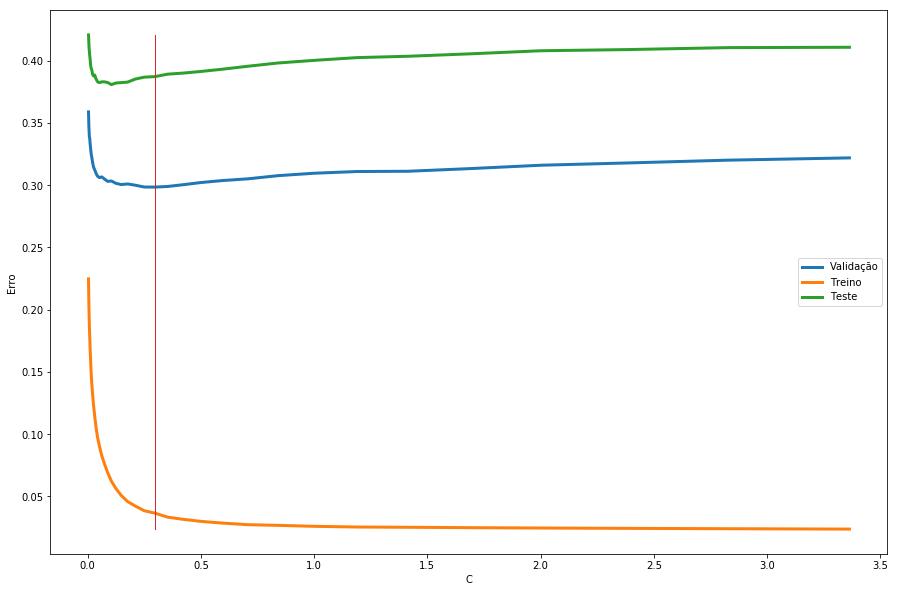

In [11]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=0, dual=True, n_jobs=-1)

Cs = 2. ** np.arange(-8, 2, 0.25)

resultados, best_score, best_param = holdout(lreg, {'C': Cs})
plot_bias_variance_tradeoff(resultados, "C", labels, best_param)

## Leave-one-out e Validação Cruzada

In [15]:
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()

inicio = time.time()

loo = LeaveOneOut()
y_pred = np.zeros((X_train.shape[0]))
for index_train, index_valid in loo.split(X_train):
    X_train_aux, X_valid = X_train[index_train], X_train[index_valid]
    y_train_aux, y_valid = y_train[index_train], y_train[index_valid]
    
    nb.fit(X_train_aux, y_train_aux)
    y_pred[index_valid] = nb.predict(X_valid)
    
fim = time.time()
print("Melhor F1 : %f; Tempo : %.2f" % (f1_score(y_train, y_pred, average = "macro"), fim - inicio))

Melhor F1 : 0.682743; Tempo : 634.30


In [16]:
print("Melhor F1 : %f;" % (f1_score(y_test, nb.predict(X_test), average = "macro")))

Melhor F1 : 0.617725;


Leave-one-out é inviável quando temos muitos dados. Eu só estou utilizando para estimar o erro em teste, mesmo assim demora um tempão. Note que eu estou usando o naïve bayes para isso e ele é um dos métodos com processo de aprendizado mais rápido, portanto, é possível enxergar que esse método fosse utilizado para escolher o valor do hiperparâmetro serio praticamente impossível obtê-lo em um tempo aceitável.

O leave-one-out é um caso especial da validação cruzada (cross-validation), quando temos N conjuntos disjuntos. Na estratégia da validação cruzada, nós divitimos o conjunto de treino em K conjuntos de tamanho similar e disjuntos, chamados de ***Folds*** (**K-Fold Cross-Validation**). Modelo é aprendido utilizando K - 1 *folds*, o *fold* deixado de fora do treino é utilizado para predição e avaliação do modelo. Esse processo é repetido K vezes para que cada *fold* seja usado para predição ao menos uma vez. Avaliação final do modelo é dado pela média das avaliações em cada *fold*. 

No leave-one-out, nós temos que K = N (quantidade de exemplos no conjunto de treino). 

T. Hastie, R. Tibshirani, J. Friedman, The Elements of Statistical Learning, Springer 2009

In [17]:
from sklearn.model_selection import validation_curve, KFold

ordered = np.argsort(y_train)

Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train[ordered], y_train[ordered], 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

Melhor F1 : 0.034772; Melhor C : 0.031250


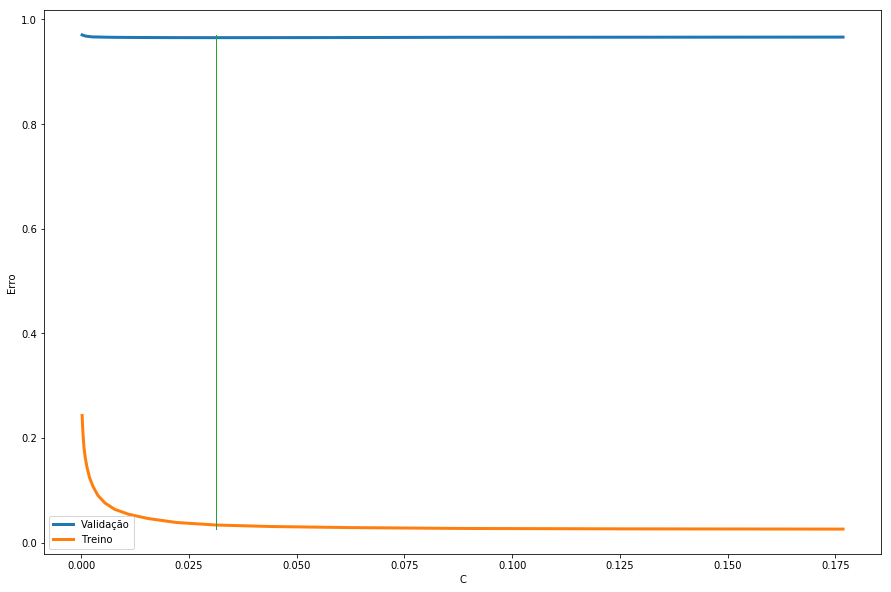

In [18]:
mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T

plot_bias_variance_tradeoff(resultados, "C", labels, Cs[best_param_index])

Melhor F1 : 0.718373; Melhor C : 0.011049


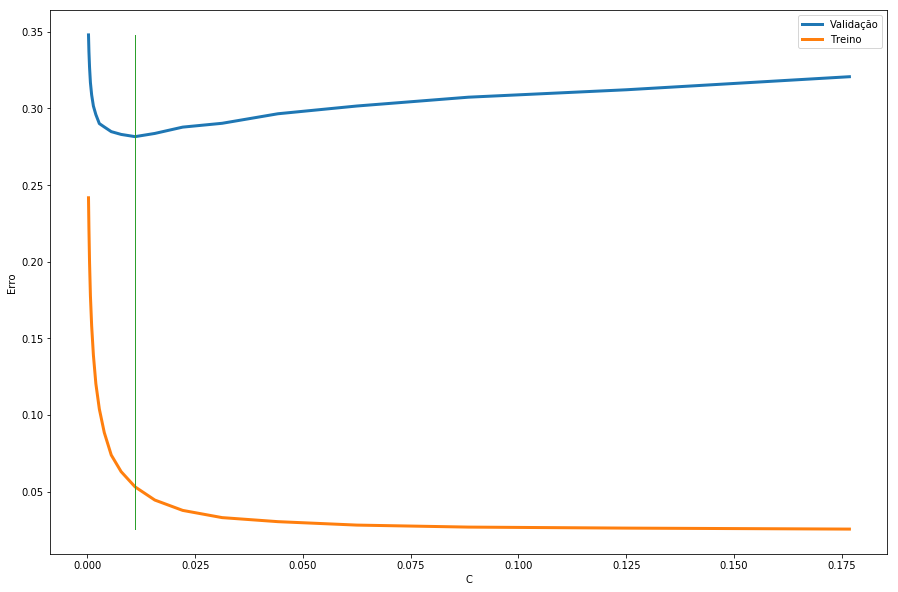

In [19]:
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, "C", labels, Cs[best_param_index])

Melhor F1 : 0.724111; Melhor C : 0.011049


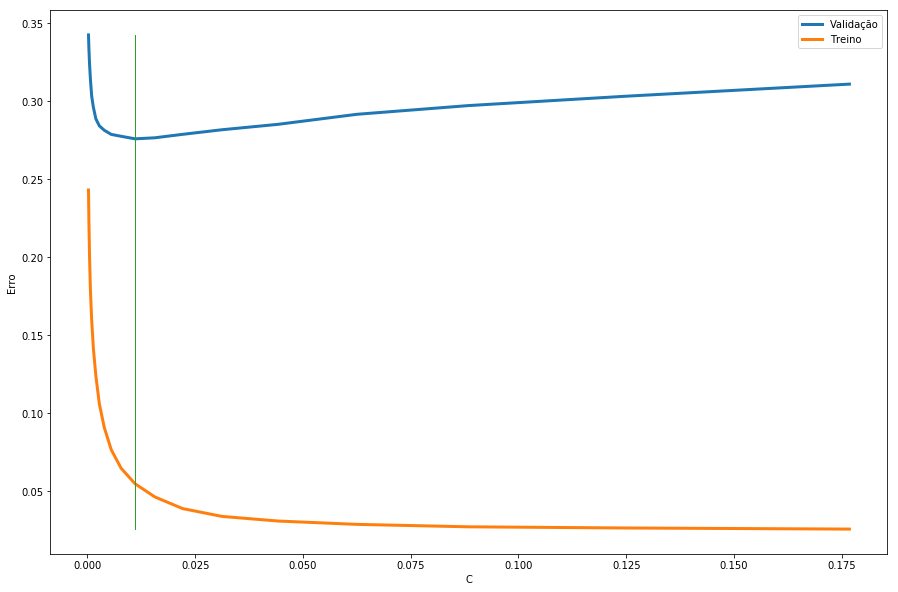

In [20]:
Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 10)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, "C", labels, Cs[best_param_index])

### Calibrando mais de um hiperparâmetro

E quando o modelo possui mais de um hiperparâmetro, como fazer a calibragem?

- Fazer a calibragem individual de cada um deles, sempre escolhendo o melhor valor para cada hiperparâmetro individual.
  
  - Não leva em consideração que os hiperparâmtros podem afetar uns aos outros
  - Menos custo
  
- Usar um tática força bruta, e tentar todas as combinações de hiperparâmetros. Essa técnica é conhecida como GridSearch
  - Pode ser muito custosa computacionalmente

- Fazer uma exploração aleatória em busca dos melhores valores
  - Computanionalmente melhor que GridSearch, porém pode ser resultar em o modelo pior que usando a técnica do GridSearch.
    
  
Scikit-learn nos oferece formas simples tanto de fazer um gridsearch quanto fazer uma busca aleatória, respectivamente com os modulos, **GridSearchCV** e **RandomizedSearchCV**.

In [21]:
"""http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html"""
svm

LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

Além do hiperparâmetro C, a implementação do SVM linear disponibilizada pelo Scikit-learn tem outros parâmetros que influenciam o aprendizado do modelo, e portanto, sua predição final. Dessa forma, podemos calibrá-los juntamente com C.

Vamos então fazer isso utilizando o  **GridSearchCV** e **RandomizedSearchCV** do scikit.

In [22]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 0.5),
    'class_weight': [None, 'balanced'],
             }
grid = GridSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.3min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.00024,  0.00035,  0.00049,  0.00069,  0.00098,  0.00138,
        0.00195,  0.00276,  0.00391,  0.00552,  0.00781,  0.01105,
        0.01562,  0.0221 ,  0.03125,  0.04419,  0.0625 ,  0.08839,
        0.125  ,  0.17678]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=1)

In [23]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (grid.best_params_, grid.best_score_))
print("Teste F1: %f" % (f1_score(y_test, grid.predict(X_test), average='macro')))

Melhores parâmetros: {'C': 0.011048543456039806, 'class_weight': 'balanced'}; Melhor F1: 0.725747
Teste F1: 0.646023


In [24]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 1.),
    'class_weight': [None],
             }
rand = RandomizedSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1, random_state=0)

rand.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
          error_score='raise',
          estimator=LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': array([ 0.00024,  0.00049,  0.00098,  0.00195,  0.00391,  0.00781,
        0.01562,  0.03125,  0.0625 ,  0.125  ]), 'class_weight': [None]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring='f1_macro', verbose=1)

In [25]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (rand.best_params_, rand.best_score_))
print("Teste F1: %f" % (f1_score(y_test, rand.predict(X_test), average='macro')))

Melhores parâmetros: {'C': 0.015625, 'class_weight': None}; Melhor F1: 0.723448
Teste F1: 0.643069


Além do hiperparâmetros do algoritmo de aprendizado de máquinas, outros fatores influenciam no aprendizado de um determinado modelo. Esse fatores podem ser, os atributos e as transformações que fazemos nos atributos, os kernels do svm e assim por diante. Nesse contexto, vamos mostrar como construir um pipeline para seleção de atributos, criação e enriquecimento de atributos. E isso tudo nós temos de escolher empiricamente, e cada combinação desse fatores gerará um modelo distinto e devemos escolher o melhor dentre eles para nós colocarmos em produção.


Ainda no contexto de classificação de textual vamos então escolher os melhores atributos, enriquecer e criar novos atributos na esperança de melhorar obtermos modelos melhores.

# Pipeline

Vamos uma funcionalidade do scikit muito boa na prática, conhecida como pipeline.

Com esse módulo podemos criar todo fluxo de transformações antes de passar os dados para o algortimo, e com isso conseguimos escolher a melhor representação para os nosso dados e os hiperparâmetros de nosso modelo.

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Vamos criar o nosso fluxo de execução
pipe = make_pipeline(
    CountVectorizer(stop_words='english', min_df=2),
    TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False),
    LinearSVC(dual=True, random_state = 0)
)

pipe

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

In [27]:
from sklearn.model_selection import StratifiedKFold

param_grid = { 
    'tfidftransformer__norm': [None, 'l2', 'max', 'l1'],
    'linearsvc__C': 2. ** np.arange(-5, 3, 1),
    'linearsvc__class_weight': [None, 'balanced'],
     }

rand = RandomizedSearchCV(pipe, param_grid, scoring='f1_macro',
                          cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=0),
                          n_jobs=-1, verbose=1, random_state=0)

rand.fit(train_20ng.data, train_20ng.target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
          error_score='raise',
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'tfidftransformer__norm': [None, 'l2', 'max', 'l1'], 'linearsvc__class_weight': [None, 'balanced'], 'linearsvc__C': array([ 0.03125,  0.0625 ,  0.125  ,  0.25   ,  0.5    ,  1.     ,
        2.     ,  4.     ])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring='f1_macro', verbose=1)

In [28]:
print(rand.best_params_)
print(rand.best_score_)

{'tfidftransformer__norm': 'l2', 'linearsvc__class_weight': None, 'linearsvc__C': 0.5}
0.75497869263


In [29]:
y_pred = rand.predict(test_20ng.data)

score = f1_score(test_20ng.target, y_pred, average="macro")
score

0.68203508152018488

In [30]:
import pandas as pd
pd.DataFrame(rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_linearsvc__C,param_linearsvc__class_weight,param_tfidftransformer__norm,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.866017,0.857290,0.752505,0.974447,1,balanced,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",3,0.741873,...,0.754169,0.974717,0.759400,0.973376,0.762455,0.974282,0.430851,0.131291,0.008038,0.000587
1,5.130215,0.888266,0.754425,0.958249,0.25,balanced,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",2,0.744454,...,0.757404,0.959228,0.760001,0.957844,0.764275,0.958009,0.407342,0.135726,0.007827,0.000565
2,10.872061,0.901811,0.713643,0.886801,1,None,l1,"{'tfidftransformer__norm': 'l1', 'linearsvc__c...",8,0.714953,...,0.712051,0.889295,0.719177,0.884624,0.723432,0.886264,0.460828,0.120610,0.008427,0.001529
3,9.327862,0.766807,0.743198,0.975843,4,balanced,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",5,0.724732,...,0.745338,0.975816,0.752723,0.975237,0.756233,0.976106,1.158952,0.100708,0.011348,0.000322
4,5.659874,0.613149,0.739246,0.975443,0.5,None,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",6,0.728667,...,0.737978,0.975267,0.749068,0.975181,0.747622,0.975570,0.545628,0.096868,0.007994,0.000188
5,4.262201,0.676865,0.754979,0.969422,0.5,None,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",1,0.741022,...,0.759086,0.969779,0.757185,0.968481,0.767806,0.969646,0.421053,0.112308,0.009022,0.000479
6,4.514845,0.669099,0.705677,0.862504,0.25,balanced,l1,"{'tfidftransformer__norm': 'l1', 'linearsvc__c...",9,0.703400,...,0.701546,0.864279,0.714464,0.861373,0.712267,0.858617,0.337784,0.106420,0.006666,0.002249
7,13.008737,0.616773,0.589249,0.975973,1,None,None,"{'tfidftransformer__norm': None, 'linearsvc__c...",10,0.587464,...,0.601847,0.975852,0.604417,0.975488,0.569717,0.976215,0.720155,0.093265,0.012760,0.000275
8,4.640763,0.552526,0.744984,0.974378,0.25,None,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",4,0.733719,...,0.741532,0.974716,0.754271,0.973395,0.756775,0.974406,0.614973,0.048491,0.008980,0.000505
9,9.524363,0.748499,0.717265,0.975959,4,balanced,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",7,0.705639,...,0.722015,0.975816,0.722834,0.975454,0.722831,0.976214,0.608623,0.091338,0.006894,0.000290


## Tentando novos atributos

Nós iremos utilizar algumas meta atributos propostos [Yang, Y. and Gopal, S. 2012], que é a distância do exemplo ao exemplo médio de cada classe. Vamos utilizar o pipeline e RandomizedSearchCV para encontrar os melhoresvalores de hiperparâmetro e qual é a melhor representação para os conjuntos de dados.

In [31]:
from sklearn.base import TransformerMixin,BaseEstimator

from sklearn.neighbors import NearestCentroid
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

"""
Yang, Y. and Gopal, S.
Multilabel classification with meta-level features in a learning-to-rank framework.
Machine Learning, vol. 88, pp. 47–68, 2012
"""
class CentroidTransformer(BaseEstimator, TransformerMixin):    
    def fit(self, X, y):
        self.centroids_ = NearestCentroid().fit(X, y).centroids_
        return self
    
    def transform(self, X):
        cos = cosine_similarity(X, self.centroids_)
        euc = 1. / (1. + euclidean_distances(X, self.centroids_))
        return np.hstack((cos, euc))

In [32]:
from sklearn.pipeline import FeatureUnion

list_features = [('centroid', CentroidTransformer()),
                 ('tfidf', TfidfTransformer(norm=None, use_idf=False, smooth_idf=False, sublinear_tf=False))]

pipe = make_pipeline(
    CountVectorizer(stop_words='english', min_df=2),
    TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False),
    FeatureUnion(list_features),
    LinearSVC(dual=True, random_state = 0)
)

param_grid = {
    'tfidftransformer__norm': [None, 'l2', 'max', 'l1'],
    'linearsvc__C': 2. ** np.arange(-5, 3, 1),
    'linearsvc__class_weight': [None, 'balanced'],
    'featureunion__transformer_list': [list_features, [list_features[0]], [list_features[1]]]
     }

rand = RandomizedSearchCV(pipe, param_grid, scoring='f1_macro',
                          cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=0),
                          n_jobs=-1, verbose=1, random_state=0, n_iter=20)

rand.fit(train_20ng.data, train_20ng.target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
          error_score='raise',
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'tfidftransformer__norm': [None, 'l2', 'max', 'l1'], 'linearsvc__class_weight': [None, 'balanced'], 'featureunion__transformer_list': [[('centroid', CentroidTransformer()), ('tfidf', TfidfTransformer(norm=None, smooth_idf=False, sublinear_tf=False,
         use_idf=False))], [('..._C': array([ 0.03125,  0.0625 ,  0.125  ,  0.25   ,  0.5    ,  1.     ,
        2.

In [33]:
print(rand.best_params_)
print(rand.best_score_)

y_pred = rand.predict(test_20ng.data)
f1_score(test_20ng.target, y_pred, average="macro")

{'tfidftransformer__norm': 'l2', 'linearsvc__class_weight': 'balanced', 'featureunion__transformer_list': [('centroid', CentroidTransformer()), ('tfidf', TfidfTransformer(norm=None, smooth_idf=False, sublinear_tf=False,
         use_idf=False))], 'linearsvc__C': 0.5}
0.756807500774


0.68507292762002936

In [34]:
pd.DataFrame(rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_featureunion__transformer_list,param_linearsvc__C,param_linearsvc__class_weight,param_tfidftransformer__norm,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,20.798585,0.827823,0.707416,0.832940,"[(centroid, CentroidTransformer())]",1,balanced,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",12,...,0.711754,0.836603,0.708723,0.834168,0.710510,0.829408,0.352524,0.159918,0.003710,0.002391
1,7.699464,1.060575,0.668860,0.773261,"[(centroid, CentroidTransformer())]",0.0625,None,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",17,...,0.675430,0.772431,0.674563,0.771871,0.668548,0.772169,1.081092,0.268143,0.005736,0.001625
2,8.982472,0.973631,0.696741,0.861321,"[(tfidf, TfidfTransformer(norm=None, smooth_id...",0.5,None,l1,"{'tfidftransformer__norm': 'l1', 'linearsvc__c...",14,...,0.700094,0.864890,0.704570,0.861340,0.696081,0.856940,1.410030,0.191485,0.005488,0.002549
3,17.910460,1.182110,0.706176,0.834804,"[(centroid, CentroidTransformer())]",0.5,None,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",13,...,0.709303,0.836759,0.708442,0.834018,0.709814,0.831816,1.082676,0.140342,0.003712,0.001926
4,37.893682,0.601063,0.708502,0.836549,"[(centroid, CentroidTransformer())]",4,balanced,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",10,...,0.710825,0.839688,0.709586,0.836177,0.715295,0.833341,1.909324,0.075549,0.004588,0.002181
5,7.369190,1.065143,0.671885,0.814850,"[(centroid, CentroidTransformer())]",0.03125,balanced,l1,"{'tfidftransformer__norm': 'l1', 'linearsvc__c...",16,...,0.684990,0.818297,0.670644,0.815814,0.673181,0.810219,1.054899,0.262834,0.007253,0.002761
6,6.712887,0.635995,0.751786,0.971542,"[(centroid, CentroidTransformer()), (tfidf, Tf...",0.125,None,max,"{'tfidftransformer__norm': 'max', 'linearsvc__...",3,...,0.753456,0.971964,0.755936,0.970867,0.764869,0.971079,1.176714,0.045773,0.009012,0.000476
7,3.652639,0.546413,0.754425,0.958249,"[(tfidf, TfidfTransformer(norm=None, smooth_id...",0.25,balanced,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",2,...,0.757404,0.959228,0.760001,0.957844,0.764275,0.958009,0.227699,0.052576,0.007827,0.000565
8,3.413821,0.535115,0.743962,0.934356,"[(tfidf, TfidfTransformer(norm=None, smooth_id...",0.125,None,l2,"{'tfidftransformer__norm': 'l2', 'linearsvc__c...",6,...,0.742358,0.936867,0.750601,0.934094,0.754744,0.933916,0.202895,0.026588,0.007609,0.001299
9,6.703574,0.957464,0.676109,0.823126,"[(centroid, CentroidTransformer()), (tfidf, Tf...",0.03125,balanced,l1,"{'tfidftransformer__norm': 'l1', 'linearsvc__c...",15,...,0.686719,0.826408,0.675556,0.822813,0.678497,0.820217,0.715842,0.224023,0.006270,0.002324
